In [1]:
import anndata
import scanpy as sc
import scgen
import pandas as pd  
import numpy as np

font = {'family' : 'Arial',
        'size'   : 14}

Global seed set to 0
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
train = sc.read("./data/PapalexiSatija2021_eccite_RNA.h5ad")

In [3]:
print(train)

AnnData object with n_obs × n_vars = 20729 × 18649
    obs: 'hto', 'guide_id', 'hto_barcode', 'gdo_barcode', 'perturbation', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo'
    var: 'ensembl_id', 'ncounts', 'ncells'


In [4]:
print(train.obs['perturbation'].unique())

['STAT2g2', 'CAV1g4', 'STAT1g2', 'CD86g1', 'IRF7g2', ..., 'SPI1g3', 'PDCD1LG2g2', 'CUL3g3', 'SPI1g2', 'MYCg4']
Length: 99
Categories (99, object): ['ATF2g1', 'ATF2g2', 'ATF2g3', 'ATF2g4', ..., 'UBE2L6g2', 'UBE2L6g3', 'UBE2L6g4', 'control']


In [5]:
print(train.obs['perturbation'])

AAACCTGAGCCAGAAC    STAT2g2
AAACCTGAGTGGACGT     CAV1g4
AAACCTGCATGAGCGA    STAT1g2
AAACCTGTCTTGTCAT     CD86g1
AAACGGGAGAACAACT     IRF7g2
                     ...   
TTTGTCAGTCACTTCC    CMTM6g1
TTTGTCAGTGACGGTA    control
TTTGTCAGTTCCACAA     ATF2g1
TTTGTCATCACGCATA     CAV1g2
TTTGTCATCTGTACGA    STAT3g1
Name: perturbation, Length: 20729, dtype: category
Categories (99, object): ['ATF2g1', 'ATF2g2', 'ATF2g3', 'ATF2g4', ..., 'UBE2L6g2', 'UBE2L6g3', 'UBE2L6g4', 'control']


In [6]:
prt=train.obs['perturbation'].unique()
list_prt=list(prt)
len(list(prt))
list_prt.remove('control')
len(list_prt)

98

In [7]:
train[train.obs['perturbation']=='control'].X

<2386x18649 sparse matrix of type '<class 'numpy.float32'>'
	with 8032261 stored elements in Compressed Sparse Column format>

In [29]:
def sample_obs(adata,size_n):
    """
    params 
    -------------
    sample for all control and stim pairs 
    size_n:the number of rows we will consider in comparison
    output x,y in sparse matrix form
    which is sample1 and sample2 drawn from two specified codition
    """

    x = adata.X
    #print(x.shape)(16893, 6998)
    n_rows=x.shape[0]
    
    df = pd.DataFrame({'x':np.arange(n_rows)})
    #shuffle the data index
    x_sample1=df['x'].sample(frac=1, replace=False).values[:size_n]
    x_sample2=df['x'].sample(frac=1, replace=False).values[:size_n]
    
    return x[x_sample1,:], x[x_sample2,:]

import random

def subset(alist, idxs):
    '''
        use idxs to subset alist
        alist: list
        idxs: list
    '''
    sub_list = []
    for idx in idxs:
        sub_list.append(alist[idx])

    return sub_list

def split_list(alist, group_num=3, shuffle=True, retain_left=False):
    '''
        split data into 3 subset and let each subset contains the len(alist)//group number of elements
        shuffle: whether shuffle the splitted data, default: True
        retain_left: if list alist is splited into the number of group_num subset and there is some element remain，
        whether take the remaining elements as a subset
    '''

    index = list(range(len(alist))) 

    
    if shuffle: 
        random.shuffle(index) 
    
    elem_num = len(alist) // group_num 
    sub_lists = {}
    
   
    for idx in range(group_num):
        start, end = idx*elem_num, (idx+1)*elem_num
        sub_lists[str(idx)] = subset(alist, index[start:end])
    
  
    if retain_left and group_num * elem_num != len(index): 
        sub_lists[str(idx+1)] = subset(alist, index[end:])
    
    return sub_lists



def sample_control_control(adata,size_n):
    """
    the sampling for ctrl and ctrl
    split the data into three samples
    shuffle the three samples
    return two data set have maximum between-sample distance
    
    """
    x = adata.X
    n_rows=x.shape[0]
    index_dict=split_list(range(n_rows))# in form {0: [1,2,3],1:[3,44,2...],3:[]}
    sample1=x[index_dict['0'],:size_n].toarray()
    sample2=x[index_dict['1'],:size_n].toarray()
    sample3=x[index_dict['2'],:size_n].toarray() 
    
    pairs={}
    pairs[0]=(sample1,sample2)
    pairs[1]=(sample1,sample3)
    pairs[2]=(sample2,sample3)
    return pairs 
        


In [94]:
#we use a function to get control and 98 stim data in order to compare the control data with each stim data 



def data_prep(adata,conditions=None,sample_ctrl=False):
    """
    param
    -----------
    adata
    return_mean: bool variable True if we want to compute mean of sampled data per cell to
    find statistic between mean of data from sample1 and sample2
    output: the sampled data from sample1 and sample2 of type array
    """
    control = adata[adata.obs["perturbation"] == conditions["x"]]
    stim = adata[adata.obs["perturbation"] == conditions["y"]]
    
    #fix the number of rows of sampled data as the minimum number of rows between sample1,sample2
    n=np.minimum(control.shape[0],stim.shape[0])
    
    x,_ = sample_obs(control,n)
    y,_ = sample_obs(stim,n)
        
    x=x.toarray()
    y=y.toarray()
        
    
    return x,y
 
def compute_from_mean(x,y,fn,if_return=False):
    """
    param
    -------
    x,y:data from sample1 and sample2
    fn: the statistic function with input x,y
    print statistic computed with mean of sample 1 and 2
    """ 
    
    x_mean = np.mean(x, axis=0).ravel()
    y_mean = np.mean(y, axis=0).ravel()
    mean = fn(x_mean,y_mean)
#     print("statistic computed with mean of sample 1 and 2:",mean)
    if if_return:
        return mean

def compute_from_sample(x,y,fn):
    """
    param
    -----------
    x,y:sampled data from sample1 and sample2 in sparse matric form
    output: the average of statistic computed between each data from sample1 and sample2
    """
#     x=x.toarray()
#     y=y.toarray()
    a=dict.fromkeys(range(x.shape[0]))
    
    for i in range(x.shape[0]):
        a[i]=fn(x[i],y[i])
        
    return np.mean(list(a.values()))

def dist_based(x,y):
    """
    transpose the data so that we can compute static between genes (columns)
    """
    m=np.minimum(x.shape[0],y.shape[0])
    x=x.T[:,:m]#delete .toarray()
    y=y.T[:,:m]
    return x,y


def test(fn,train,metric_str):
    """
    fn: the function for computing specific statistic to apply 
    print out the test result for statistic between (stim,ctrl) and (ctrl,ctrl)
    
    """
    list_stim=list(train.obs['perturbation'].unique())
    list_stim.remove('control')
    conditions={"x":"control","y":"stim"}
    
    difference=[]
    if_stim=['stim']*len(list_stim)
    
    for stim in list_stim:
        conditions["y"]=str(stim)
#         print(conditions)
#         print("mean of computed statistics:",fn(train,conditions))
        difference.append(fn(train,conditions))
    
    #lastly,for (ctrl,ctrl) where we apply a different sampling method, get three points 
    conditions["y"]="control"
    control = train[train.obs["perturbation"] == conditions["x"]]
    print(conditions)
    pairs=sample_control_control(control,control.shape[0])
    for i in range(3):
        (x,y)=pairs[i]
        print("mean of computed statistics for (contrl, control):",fn(train,conditions,True,x,y))
        #set the sample_ctrl True
        difference.append(fn(train,conditions,True,x,y))
    zero=['control']*3
    if_stim=if_stim + zero
    metric=[metric_str]*len(if_stim)
        
    return difference,if_stim,metric    
              
              

In [97]:
from scipy import stats
def calc_pearson(adata, conditions, sample_ctrl=False,ctrl1=None,ctrl2=None):
    """
    param
    ---------
    adata
    condition: dictionary pass to adata to get sample1 and sample2 from specific 'condition'
    fn: function for computing pearson coefficient 
    -----------
    output: the average of pearson coefficient computed between each data from sample1 and sample2
    """
    fn=lambda x,y: stats.pearsonr(x,y).statistic
    
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
      
    
    compute_from_mean(x,y,fn,sample_ctrl)
    
    
    pearson_obs=dict.fromkeys(range(x.shape[0]))
    for i in range(x.shape[0]):
        #use pd
        df = pd.DataFrame({'x':x[i], 'y':y[i]})
        matrix=df.corr(method='pearson').values
        pearson_obs[i] = matrix[0,1]
    
    pr=list(pearson_obs.values())
    
    return np.mean(pr)

difference0,if_stim0,metric0=test(calc_pearson,train,'pearson')


{'x': 'control', 'y': 'control'}
mean of computed statistics for (contrl, control): 0.7569974100830841
mean of computed statistics for (contrl, control): 0.7608420447210422
mean of computed statistics for (contrl, control): 0.7603276121985171


<AxesSubplot:xlabel='metric', ylabel='difference'>

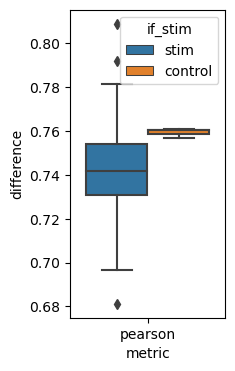

In [98]:
df=pd.DataFrame({'difference':difference0, 'if_stim':if_stim0, 'metric':metric0})
# print(difference,if_stim,metric)
plt.figure(figsize=(2, 4))
import seaborn as sns
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

In [78]:
from scipy import stats
def calc_mae(adata, conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    fn=lambda x,y: np.mean(np.abs(y-x))
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
    compute_from_mean(x,y,fn)
    return compute_from_sample(x,y,fn)

difference,if_stim,metric=test(calc_mae,train,'mae')

{'x': 'control', 'y': 'STAT2g2'}
statistic computed with mean of sample 1 and 2: 0.0675341
mean of computed statistics: 0.7597714
statistic computed with mean of sample 1 and 2: 0.0642694
{'x': 'control', 'y': 'CAV1g4'}
statistic computed with mean of sample 1 and 2: 0.07869735
mean of computed statistics: 0.76917577
statistic computed with mean of sample 1 and 2: 0.0783556
{'x': 'control', 'y': 'STAT1g2'}
statistic computed with mean of sample 1 and 2: 0.29886293
mean of computed statistics: 0.86853415
statistic computed with mean of sample 1 and 2: 0.2663782
{'x': 'control', 'y': 'CD86g1'}
statistic computed with mean of sample 1 and 2: 0.041130885
mean of computed statistics: 0.75427675
statistic computed with mean of sample 1 and 2: 0.04662883
{'x': 'control', 'y': 'IRF7g2'}
statistic computed with mean of sample 1 and 2: 0.08282774
mean of computed statistics: 0.7160296
statistic computed with mean of sample 1 and 2: 0.12116012
{'x': 'control', 'y': 'ATF2g4'}
statistic computed wi

statistic computed with mean of sample 1 and 2: 0.050544195
mean of computed statistics: 0.74133253
statistic computed with mean of sample 1 and 2: 0.055805594
{'x': 'control', 'y': 'MARCH8g1'}
statistic computed with mean of sample 1 and 2: 0.076477945
mean of computed statistics: 0.72288066
statistic computed with mean of sample 1 and 2: 0.061659273
{'x': 'control', 'y': 'IFNGR2g4'}
statistic computed with mean of sample 1 and 2: 0.16963527
mean of computed statistics: 0.73868465
statistic computed with mean of sample 1 and 2: 0.18354993
{'x': 'control', 'y': 'NFKBIAg2'}
statistic computed with mean of sample 1 and 2: 0.08157607
mean of computed statistics: 0.77099913
statistic computed with mean of sample 1 and 2: 0.072615646
{'x': 'control', 'y': 'MARCH8g4'}
statistic computed with mean of sample 1 and 2: 0.043268587
mean of computed statistics: 0.732086
statistic computed with mean of sample 1 and 2: 0.051123384
{'x': 'control', 'y': 'IFNGR2g1'}
statistic computed with mean of sam

statistic computed with mean of sample 1 and 2: 0.27611065
mean of computed statistics: 0.7824247
statistic computed with mean of sample 1 and 2: 0.25531864
{'x': 'control', 'y': 'SPI1g1'}
statistic computed with mean of sample 1 and 2: 0.27366462
mean of computed statistics: 0.57889736
statistic computed with mean of sample 1 and 2: 0.26084125
{'x': 'control', 'y': 'UBE2L6g4'}
statistic computed with mean of sample 1 and 2: 0.09238994
mean of computed statistics: 0.78292567
statistic computed with mean of sample 1 and 2: 0.0890214
{'x': 'control', 'y': 'POU2F2g4'}
statistic computed with mean of sample 1 and 2: 0.16527532
mean of computed statistics: 0.8554922
statistic computed with mean of sample 1 and 2: 0.17171262
{'x': 'control', 'y': 'MYCg2'}
statistic computed with mean of sample 1 and 2: 0.19364645
mean of computed statistics: 0.72897005
statistic computed with mean of sample 1 and 2: 0.20584549
{'x': 'control', 'y': 'BRD4g1'}
statistic computed with mean of sample 1 and 2: 0.

<AxesSubplot:xlabel='metric', ylabel='difference'>

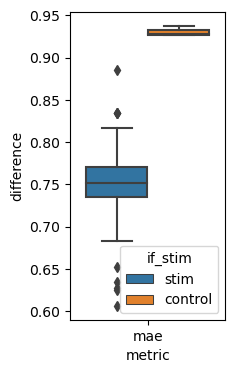

In [79]:
# print(difference2,if_stim2,metric2)
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference, 'if_stim':if_stim, 'metric':metric})
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

{'x': 'control', 'y': 'control'}


<AxesSubplot:xlabel='metric', ylabel='difference'>

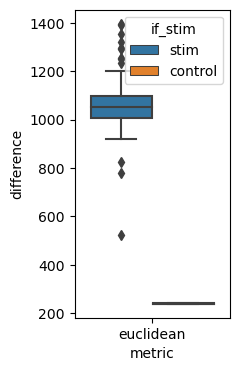

In [84]:
def calc_euclidean_d(adata, conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    fn=lambda x,y: np.linalg.norm(x-y)
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
    compute_from_mean(x,y,fn) 
    return compute_from_sample(x,y,fn)

difference2,if_stim2,metric2=test(calc_euclidean_d,train,'euclidean')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference2, 'if_stim':if_stim2, 'metric':metric2})
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")


{'x': 'control', 'y': 'control'}


<AxesSubplot:xlabel='metric', ylabel='difference'>

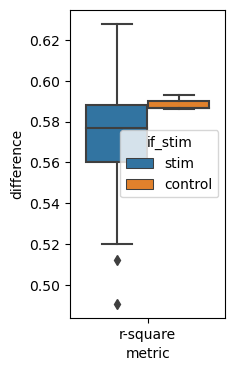

In [85]:
def calc_r(adata,conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    fn=lambda x,y: stats.linregress(x,y)[2]**2
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
    compute_from_mean(x,y,fn)
    return compute_from_sample(x,y,fn)

difference3,if_stim3,metric3=test(calc_r,train,'r-square')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference3, 'if_stim':if_stim3, 'metric':metric3})
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/User

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/User

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/User

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/User

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/User

{'x': 'control', 'y': 'control'}


<AxesSubplot:xlabel='metric', ylabel='difference'>

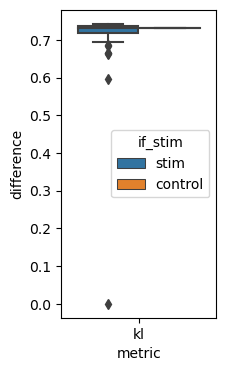

In [86]:
from scipy.spatial import distance
from scipy.stats import ttest_ind
#distribution based metrics 
#use Jensen-Shannon divergence to replace formula of kl divergence since kl diergence has
#inf result for sparse data 
def average_dist_metric(x,y,fn):
    kl=0
    count_nan=0
    for i in range(x.shape[0]):

        sparse=fn(x[i],y[i])
        if np.isnan(sparse):#nan: caused by division by 0-vector(vec of all 0)
            count_nan+=1   
        else:
            kl+=sparse
    if x.shape[0]==count_nan:
        return 0 # note that 0 for t-statistics  means that the result is inconclusive and more data may be needed to make a definitive conclusion.
    else:
        return kl/(x.shape[0]-count_nan)

def calc_kl(adata, conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)#only for distribution based methods
    fn=lambda x,y: distance.jensenshannon(x,y)
    return average_dist_metric(x,y,fn)

difference4,if_stim4,metric4=test(calc_kl,train,'kl')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference4, 'if_stim':if_stim4, 'metric':metric4})
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/meiqiliu/miniforge3/envs/fa_base2/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/var/folders/12/d54y_pk95zdbftjg_qkcj_c80000gq/T/ipykernel_1695/31322411.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  fn=lambda x,y: stats.ttest_ind(x,y, equal_var=True)[0]


{'x': 'control', 'y': 'control'}


<AxesSubplot:xlabel='metric', ylabel='difference'>

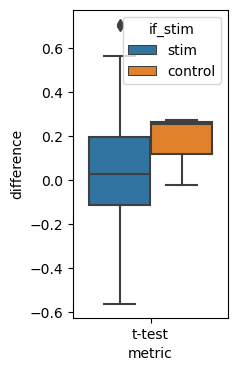

In [88]:
def average_dist_metric(x,y,fn):
    kl=0
    count_nan=0
    for i in range(x.shape[0]):

        sparse=fn(x[i],y[i])
        if np.isnan(sparse):#nan: caused by division by 0-vector(vec of all 0)
            count_nan+=1   
        else:
            kl+=sparse
    if x.shape[0]==count_nan:
        return 0 # note that 0 for t-statistics  means that the result is inconclusive and more data may be needed to make a definitive conclusion.
    else:
        return kl/(x.shape[0]-count_nan)
    
def t_test(adata, conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)#only for distribution based methods
    fn=lambda x,y: stats.ttest_ind(x,y, equal_var=True)[0]
    return average_dist_metric(x,y,fn)

difference5,if_stim5,metric5=test(t_test,train,'t-test')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference5, 'if_stim':if_stim5, 'metric':metric5})
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

mmd
0.00014416873455047607
mmd
mmd
0.00015652179718017578
mmd
mmd
0.0005935579538345337
mmd
mmd
0.00011605024337768555
mmd
mmd
0.00046174973249435425
mmd
mmd
0.00013128668069839478
mmd
mmd
0.00023311376571655273
mmd
mmd
0.00011947005987167358
mmd
mmd
0.00013728439807891846
mmd
mmd
0.00014960020780563354
mmd
mmd
0.00014118105173110962
mmd
mmd
0.0001453682780265808
mmd
mmd
0.00018597394227981567
mmd
mmd
0.0001814514398574829
mmd
mmd
0.00018204748630523682
mmd
mmd
0.0001195371150970459
mmd
mmd
0.00013253837823867798
mmd
mmd
0.00015488266944885254
mmd
mmd
0.00026163458824157715
mmd
mmd
0.0001307949423789978
mmd
mmd
0.0004240795969963074
mmd
mmd
0.00021019577980041504
mmd
mmd
0.00014981627464294434
mmd
mmd
0.0001304149627685547
mmd
mmd
0.00015895813703536987
mmd
mmd
0.0001202113926410675
mmd
mmd
0.00025704503059387207
mmd
mmd
0.000176355242729187
mmd
mmd
0.00011686980724334717
mmd
mmd
0.000251084566116333
mmd
mmd
0.0001606196165084839
mmd
mmd
0.00012852996587753296
mmd
mmd
0.000135026872158

<AxesSubplot:xlabel='metric', ylabel='difference'>

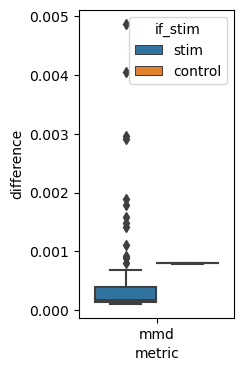

In [95]:
from sklearn import metrics
#very slow ~20min
def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    
    print("mmd")
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def mmd(adata, conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)
    print(mmd_rbf(x,y))

    return mmd_rbf(x,y)

difference6,if_stim6,metric6=test(mmd,train,'mmd')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference6, 'if_stim':if_stim6, 'metric':metric6})
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

{'x': 'control', 'y': 'control'}
mean of computed statistics for (contrl, control): 0.06966212761022104
mean of computed statistics for (contrl, control): 0.06343449999209223
mean of computed statistics for (contrl, control): 0.061702172526319675


<AxesSubplot:xlabel='metric', ylabel='difference'>

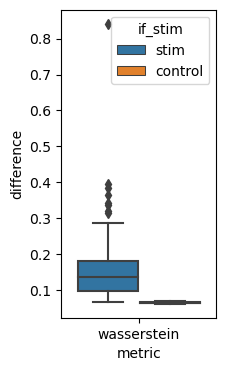

In [96]:
def calc_wasserstein(adata, conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    fn=lambda x,y: stats.wasserstein_distance(x,y)
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
    x,y=dist_based(x,y)
    return compute_from_sample(x,y,fn)


difference7,if_stim7,metric7=test(calc_wasserstein,train,'wasserstein')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference7, 'if_stim':if_stim7, 'metric':metric7})
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")